# First steps
### Really short introduction to filter functions
In the filter function formalism one tries to quantify the decoherence of a qubit subject to a given control operation, or 'pulse sequence', by capturing the susceptibility of the system undergoing the time evolution generated by the control operation to noise in the frequency domain in a so-called 'filter function', $F(\omega)$. Then, with the noise expressed through its (two-sided) power spectral density $S(\omega)$, the decoherence function is given by

$$
    W(t) = \exp\left(-\chi(t)\right)
$$

with

$$
    \chi(t) = \frac{1}{d}\int\frac{\mathrm{d}\omega}{2\pi} F(\omega) S(\omega).
$$

Therefore, the decoherence can be very intuitively understood and studied by examining the filter function in the frequency domain -- if it is large, the system will be very susceptible to noise at that frequency, while if it is small, noise of that frequency will be 'filtered out'. In this regard, the filter function is very similar to the transfer function of electrical circuits.

Other filter functions than the one *fidelity* filter function above which describes phase coherence may be defined in a similar way and obtained as linear combinations of *generalized* filter functions. These functions are defined with respect to an orthonormal operator basis $\lbrace C_k\rbrace_{k=0}^{d^2-1}$ and the fidelity filter function, for example, may be obtained from them by tracing out the basis indices, $F(\omega) = \mathrm{tr}(F_{kl}(\omega))$.

### The `PulseSequence` class
The central object of this package is the `PulseSequence` class. It is used to represent the control operation implementing a certain Hamiltonian ${H}_c$ and the sensitivities of the noise afflicting the system. More concisely, the total Hamiltonian of the system is modelled as

\begin{align*}
    {H} &= {H}_c + {H}_n \\
    {H}_c &= \sum_i a_i(t) A_i \\
    {H}_n &= \sum_\alpha s_\alpha(t) b_\alpha(t) B_\alpha \\
\end{align*}

where $A_i$ and $B_\alpha$ are the control and noise operators, respectively, $a_i(t)$ the control strength of $A_i$ at time $t$, $s_\alpha(t)$ a deterministic time dependence of the noise operators to model, for instance, non-linear coupling to the noise sources, and $b_\alpha(t)$ classically fluctuating noise variables. Since the noise is captured in a spectral density function that accounts for different realizations of the random noise, the $b_\alpha(t)$ are not required at instantiation of a `PulseSequence` instance. Note that we always calculate in units where $\hbar\equiv 1$.

The `PulseSequence` class requires three positional arguments at instantiation; `H_c`, `H_n`, and `dt`, with `dt` the time-deltas of piece-wise constant control. The former two represent the control and noise Hamiltonians and are passed in the same nested-list-of-lists structure of operators and coefficient lists similar to that required by [QuTiP](http://qutip.org/) (the difference being that QuTiP requires implicit functions for calculating the coefficients instead of explicit values). Optionally, we pass unique identifiers for each operator as a third element of the list. That is, 

```python
    H = [[oper1, coeffs1, identifier1],
         [oper2, coeffs2, identifier2], ...]
```

The filter function can then be calculated by calling the `get_filter_function` method of the `PulseSequence` instance with a list of frequencies.


## A simple example
To illustrate the instantiation syntax, we would like to compute the fidelity filter function for a Free Induction Decay (FID) experiment, which is given by [[Cywiński et al. (2008)]]

$$
    F(\omega\tau) = \frac{2\sin^2\frac{\omega\tau}{2}}{\omega^2}
$$

with $\tau$ the pulse duration. Note that due to different conventions this expression looks slightly different to the literature.

We shall assume to have full control over the $x$-axis of our qubit, there is a constant energy splitting along the $z$-axis, and further that said qubit is subject to dephasing noise along the $z$-axis as well as depolarizing noise along the $x$-axis corresponding to a noisy control. As the FID experiment simply lets the qubit evolve freely for a variable time, the pulse sequence is particularly simple: we do nothing (since we do not do an actual experiment we don't need to rotate the Bloch vector onto the equator and back up for measurement).

We set up the Hamiltonian as follows:

[Cywiński et al. (2008)]: https://arxiv.org/abs/0712.2225

In [1]:
import numpy as np
import qutip as qt

import filter_functions as ff

%matplotlib notebook

In [2]:
# Pauli matrices
X, Y, Z = qt.sigmax(), qt.sigmay(), qt.sigmaz()

# Control Hamiltonian
H_c = [
    [X/2, [0], 'X'],       # We don't apply any control
    [Z/2, [4*np.pi], 'Z']  # Qubit splitting, hbar == 1
]

# Noise Hamiltonian
H_n = [
    [X/2, [1], 'X'],
    [Z/2, [1], 'Z']
]

Now we can define the time steps and initialize a `PulseSequence`:

In [3]:
# Pulse duration (== measurement time)
tau = 0.2
# Time steps, we only have one
dt = [tau]

FID = ff.PulseSequence(H_c, H_n, dt)

In order to inspect the filter function, we can plot it against frequency and compare with the analytic solution (the `analytic` module follows the conventions from [Cywiński et al. (2008)] so we have to rescale).

[Cywiński et al. (2008)]: https://arxiv.org/abs/0712.2225

<IPython.core.display.Javascript object>


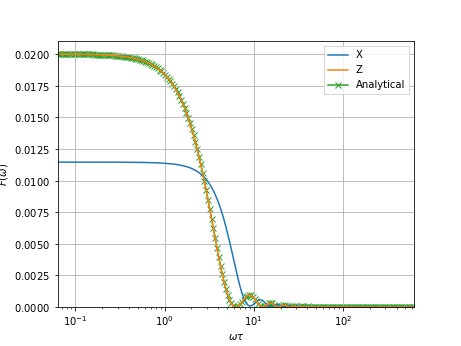

In [4]:
from filter_functions import analytic, plotting

# Generate logarithmically spaced frequencies over an interval which generally
# captures the important regions of the filter function. Since the filter
# function is symmetric in frequency we only need to calculate it for positive
# frequencies.
omega = ff.util.get_sample_frequencies(FID, n_samples=200, spacing='log')
# Plot the filter function.
fig, ax, legend = plotting.plot_filter_function(FID, omega)
# Plot the analytic solution into the same plot
ax.plot(omega*tau, analytic.FID(omega*tau)/omega**2,
        'x-', label='Analytical', zorder=0)
# Update legend
legend = ax.legend()

As we can see, the filter function is nonzero for DC frequencies and drops to zero for frequencies larger than the measurement window $2\pi/\tau$. Of course, high frequencies inherently affect the qubit less as the noise averages out due to the large number of oscillations on the time scale of the 'pulse' (in this case just the measurement window). Moreoever, dephasing noise affects the qubit more strongly at low frequencies than noise on our hypothetical control parameter.

We may also inspect the evolution of the Bloch vector using a wrapper for QuTiP's `Bloch` plotting module:

<IPython.core.display.Javascript object>


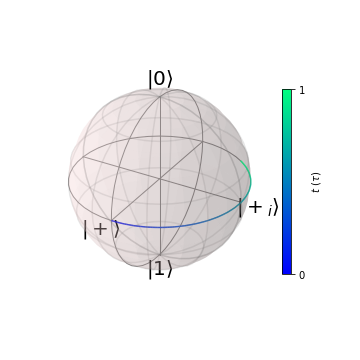

In [5]:
# Initial state the +1 eigenstate of X
psi_i = (qt.basis(2, 0) + qt.basis(2, 1))/np.sqrt(2)

plotting.plot_bloch_vector_evolution(FID, psi0=psi_i, n_samples=101,
                                     figsize=(5, 5), add_cbar=True)

### Generalized filter functions
As mentioned above, we can of course also compute the fidelity filter function from the generalized filter functions. These may be obtained by specifying a corresponding flag when calling `PulseSequence.get_filter_function()`. We can verify that the fidelity filter function above is calculated correctly by taking the trace over the basis elements of the generalized filter functions. By convention, the first two axes of this quantity correspond to the noise operators $B_\alpha,B_\beta$, and the third and fourth correspond to the basis elements $C_k,C_l$.

In [6]:
F_fid = FID.get_filter_function(omega, which='fidelity')
F_gen = FID.get_filter_function(omega, which='generalized')

print(F_fid.shape, F_gen.shape)
print(np.allclose(F_fid, F_gen.trace(axis1=2, axis2=3)))

(2, 2, 200) (2, 2, 4, 4, 200)
True


## A slightly more involved example
As a slightly more involved example, we implement a Spin Echo (SE) pulse, that is, a $\pi$-pulse sandwiched between two periods of free evolution. Here, the analytical solution in the 'Bang-Bang' limit ($\delta$-shaped pulses) is given by

$$
    F(\omega\tau) = \frac{8\sin^4\frac{\omega\tau}{4}}{\omega^2}.
$$

This time, we assume a realistic singlet-triplet exchange qubit in a magnetic field. In this case, the control Hamiltonian is given by

$$
    {H}_c = \Delta B_z\frac{\sigma_z}{2} + J(\epsilon(t))\frac{\sigma_x}{2}
$$

with a phenomenological $J(\epsilon(t))=\exp(\epsilon(t)/\epsilon_0)$ where $\epsilon(t)$ is the controllable detuning and $\epsilon_0$ a normalization factor. Since the parameter that is controlled from the lab and that is physically afflicted by noise, $\epsilon$, enters the Hamiltonian non-trivially (i.e. not linearly) through the exchange coupling $J$, the pulse is also affected non-trivally by $\epsilon$-noise. We can to first order account for this dependence by including the derivative of $J$ with respect to $\epsilon$ as a noise sensitivity;

$$
    s_\epsilon(t) = \frac{\partial J(\epsilon(t))}{\partial\epsilon(t)} = J(\epsilon(t))/\epsilon_0.
$$

We may thus implement a spin echo pulse as follows:

In [7]:
# pi-pulse duration
tau_pi = .04
# Normalization factor
epsilon_0 = 10

# Control Hamiltonian
J = np.array([0, np.pi/tau_pi, 0])
dBz = [4*np.pi]*3

# If we don't supply custom identifiers, the operators are labelled 
# A_0, A_1, ... for control and B_0, B_1, ... for noise operators
H_c = [
    [X/2, J],
    [Z/2, dBz]
]

# Noise Hamiltonian
H_n = [
    [X/2, J/epsilon_0],
    [Z/2, [1]*3]  # B-field 
]

# Time steps
dt = [(tau - tau_pi)/2, tau_pi, (tau - tau_pi)/2]

SE = ff.PulseSequence(H_c, H_n, dt)

Again, we plot the filter functions and Bloch vector evolution:

<IPython.core.display.Javascript object>


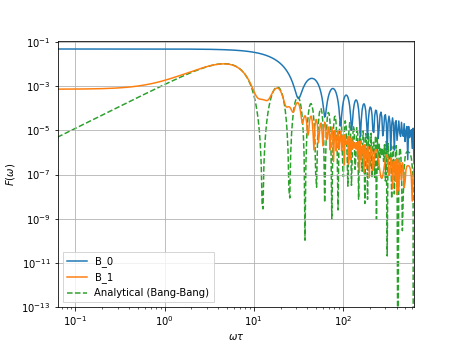

<IPython.core.display.Javascript object>


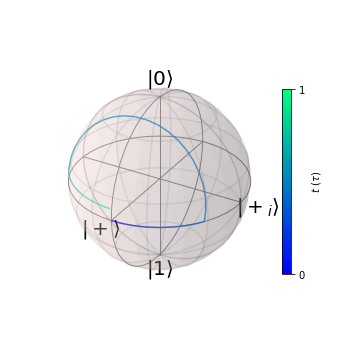

In [8]:
omega = ff.util.get_sample_frequencies(SE, n_samples=400, spacing='log')
# Plot the filter function
fig, ax, legend = plotting.plot_filter_function(SE, omega, yscale='log')
ax.set_ylim(bottom=1e-13)
# Plot the analytical solution
ax.plot(omega*tau, analytic.SE(omega*tau)/omega**2, '--',
        label='Analytical (Bang-Bang)', zorder=0)
legend = ax.legend()

plotting.plot_bloch_vector_evolution(SE, psi0=psi_i, n_samples=101,
                                     figsize=(5, 5), add_cbar=True)

The discrepancy to the analytical solution is due to the finite pulse width we have chosen here. We can see that, contrary to the FID-like filter function along $\sigma_x$, the dephasing filter function of the SE pulse drops to (almost) zero for DC noise, affirming that indeed the pulse cancels dephasing as it filters out noise frequencies slower than the pulse duration.